# Sélection des variables
## Import des données
L'étude se fera à partir de janvier 1990.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Import de la variable cible : conso

conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
conso = conso.set_index('Période').replace({',':'.'},regex=True).astype('float64')

# Import des variables explicatives : goods, services, retail_trade

goods = pd.read_csv('Ressources/Goods index.csv',sep=';').drop(range(6))
goods = goods.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

services = pd.read_csv('Ressources/Services index.csv',sep=';').drop(range(4))
services = services.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

retail_trade = pd.read_csv('Ressources/Retail trade index.csv',sep=';').drop(range(4)).reset_index().drop('index',axis=1)
retail_trade = retail_trade.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

# Constitution de sous-datasets

goods_brut = goods.loc[:,[column.endswith('(Brut)') for column in goods.columns]]
goods_CVS = goods.loc[:,[column.endswith('(CVS)') for column in goods.columns]]
goods_tendance = goods.loc[:,[column.endswith('(Tendance)') for column in goods.columns]] # Pour goods

services_brut = services.loc[:,[column.endswith('(Brut)') for column in services.columns]]
services_CVS = services.loc[:,[column.endswith('(CVS)') for column in services.columns]]
services_tendance = services.loc[:,[column.endswith('(Tendance)') for column in services.columns]] # Pour services

retail_brut = retail_trade.loc[:,[column.endswith('(Brut)') for column in retail_trade.columns]]
retail_CJO_CVS = retail_trade.loc[:,[column.endswith('(CJO CVS)') for column in retail_trade.columns]]
retail_brut_valeur = retail_brut.filter(regex='indice en valeur')
retail_brut_volume = retail_brut.filter(regex='indice en volume')
retail_CJO_CVS_valeur = retail_CJO_CVS.filter(regex='indice en valeur')
retail_CJO_CVS_volume = retail_CJO_CVS.filter(regex='indice en volume') # Pour retail_trade

# Réunion dans des matrices X, X-brut, X-CVS, X-tendance

services_90 = services.loc['Déc 2019':'Jan 1990'].reset_index()
goods_90 = goods.loc[:'01/01/1990'].reset_index()
goods_90['Date'] = retail_trade.reset_index()['Date'] 

services_2000 = services.loc['Déc 2019':'Jan 2000'].reset_index()
goods_2000 = goods.loc[:'01/01/2000'].reset_index()
goods_2000['Date'] = retail_trade.reset_index()['Date']

# Constitution de la variable cible yty-var

var = []
for i in range(4,len(conso),1):
    var.append(float(conso['TOTAL '].iloc[i]/conso['TOTAL '].iloc[i-4] - 1))
yty_var = pd.DataFrame({'Variations de la consommation':var,
'Date':list(conso.index)[4:]})
yty_var = yty_var.set_index('Date')

yty_var_2000 = yty_var.loc['2000T1':]

# On commence par ajuster les nombres de ligne et les index.

X = retail_trade.merge(services_90,on='Date').merge(goods_90,on='Date').set_index('Date')
X_2000 = retail_trade.merge(services_2000,on='Date').merge(goods_2000,on='Date').set_index('Date')
X_2000_trimestriel = pd.DataFrame([X_2000.iloc[3*k:3*(k+1)].mean() for k in range(int(len(X_2000)/3))],columns=X_2000.columns,index=yty_var_2000.index[::-1])
X_2000_trimestriel = X_2000_trimestriel.fillna(method='ffill')

# Normalisation des matrices

Y_norm = StandardScaler().fit_transform(yty_var)
X_norm = StandardScaler().fit_transform(X)

Y_norm_2000 = pd.DataFrame(StandardScaler().fit_transform(yty_var_2000),index=yty_var_2000.index,columns=yty_var_2000.columns).astype('float64')
X_norm_2000 = pd.DataFrame(StandardScaler().fit_transform(X_2000_trimestriel[::-1]),index=X_2000_trimestriel[::-1].index,columns=X_2000_trimestriel[::-1].columns).astype('float64')
X_norm_2000 = X_norm_2000.fillna(X_norm_2000.mean())


## Régression Lasso

In [37]:
coefs = pd.DataFrame(index=X_norm_2000.columns)
alphas = np.linspace(0,0.5)

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_norm_2000, Y_norm_2000)
    coefs[str(alpha)] = clf.coef_

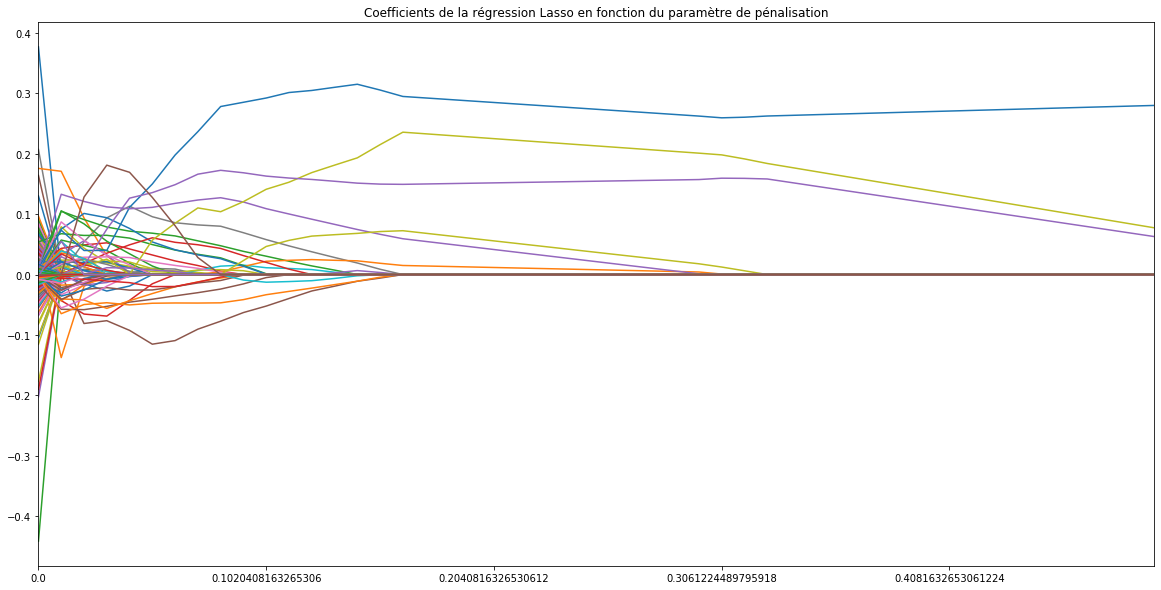

In [47]:
fig, ax = plt.subplots()

coefs.T.plot(ax=ax,legend=False,title="Coefficients de la régression Lasso en fonction du paramètre de pénalisation",figsize=(20,10))


On peut ainsi penser à 4 modèles différents:
* Un très complexe avec alpha = 0.03
* Un complexe avec alpha = 0.06
* Un simple avec alpha = 0.175
* Un très simple avec alpha = 0.35

Pour étudier la corrélation des variables, on peut se pencher sur les modèles complexes (alpha petit).

### Quelles sont les variables retenues ?

In [48]:
coefs2 = pd.DataFrame(index=X_norm_2000.columns)
alphas = [0.03,0.06,0.175,0.35]

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_norm_2000, Y_norm_2000)
    coefs2[str(alpha)] = clf.coef_

In [55]:
variables_modele_tres_complexe = list(coefs2.loc[coefs2['0.03']!=0].index)
variables_modele_complexe = list(coefs2.loc[coefs2['0.06']!=0].index)
variables_modele_simple = list(coefs2.loc[coefs2['0.175']!=0].index)
variables_modele_tres_simple = list(coefs2.loc[coefs2['0.35']!=0].index)

Ces dernières variables permettent d'étudier plus succintement les corrélations avec yty-var. 